In [74]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
from scipy import stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
import torch
import os
import random
from sklearn.preprocessing import StandardScaler


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.transforms import Compose


from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from torch_geometric.data import Data, download_url, extract_gz
from torch_geometric.nn import GAE, GCNConv, VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree


In [2]:
# read in disgnet disease gene associations
disgenet_raw = pd.read_csv('../data/processed/new_all_propagated_disgenet_genes.tsv', delimiter= '\t')
disgenet_raw.head(15)
print(disgenet_raw.dtypes)

gene_id        int64
mondo_id      object
mondo_term    object
dtype: object


In [3]:
# get seed set into a list
tb_pos_disgenes = [str(gene) for gene in set(disgenet_raw['gene_id'].tolist())]

In [4]:
# read hpo data
# read in network data file
biogrid_raw = pd.read_csv("../data/bigdatasets/biogrid_network.txt", sep='\t') 

#take a look
biogrid_raw.head()


,#ID Interactor A,ID Interactor B,Alt IDs Interactor A,Alt IDs Interactor B,Aliases Interactor A,Aliases Interactor B,Interaction Detection Method,Publication 1st Author,Publication Identifiers,Taxid Interactor A,Taxid Interactor B,Interaction Types,Source Database,Interaction Identifiers,Confidence Values
0,entrez gene/locuslink:6416,entrez gene/locuslink:2318,biogrid:112315|entrez gene/locuslink:MAP2K4|un...,biogrid:108607|entrez gene/locuslink:FLNC|unip...,entrez gene/locuslink:JNKK(gene name synonym)|...,entrez gene/locuslink:ABP-280(gene name synony...,"psi-mi:""MI:0018""(two hybrid)",Marti A (1997),pubmed:9006895,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:103,-
1,entrez gene/locuslink:84665,entrez gene/locuslink:88,biogrid:124185|entrez gene/locuslink:MYPN|unip...,biogrid:106603|entrez gene/locuslink:ACTN2|uni...,entrez gene/locuslink:CMD1DD(gene name synonym...,entrez gene/locuslink:CMD1AA(gene name synonym),"psi-mi:""MI:0018""(two hybrid)",Bang ML (2001),pubmed:11309420,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:117,-
2,entrez gene/locuslink:90,entrez gene/locuslink:2339,biogrid:106605|entrez gene/locuslink:ACVR1|uni...,biogrid:108625|entrez gene/locuslink:FNTA|unip...,entrez gene/locuslink:ACTRI(gene name synonym)...,entrez gene/locuslink:FPTA(gene name synonym)|...,"psi-mi:""MI:0018""(two hybrid)",Wang T (1996),pubmed:8599089,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:183,-
3,entrez gene/locuslink:2624,entrez gene/locuslink:5371,biogrid:108894|entrez gene/locuslink:GATA2|uni...,biogrid:111384|entrez gene/locuslink:PML|unipr...,entrez gene/locuslink:DCML(gene name synonym)|...,entrez gene/locuslink:MYL(gene name synonym)|e...,"psi-mi:""MI:0018""(two hybrid)",Tsuzuki S (2000),pubmed:10938104,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:278,-
4,entrez gene/locuslink:6118,entrez gene/locuslink:6774,biogrid:112038|entrez gene/locuslink:RPA2|entr...,biogrid:112651|entrez gene/locuslink:STAT3|uni...,entrez gene/locuslink:REPA2(gene name synonym)...,entrez gene/locuslink:ADMIO(gene name synonym)...,"psi-mi:""MI:0018""(two hybrid)",Kim J (2000),pubmed:10875894,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:418,-


In [5]:
# biogrid has proteins for other species. I want only the human proteins so filter these out.
human_biogrid_raw =biogrid_raw[(biogrid_raw['Taxid Interactor A'] == "taxid:9606") & (biogrid_raw['Taxid Interactor B'] == "taxid:9606")]

In [6]:
# Further data exploration. Check for nas, shape of data
# check for nas
human_biogrid_raw.head()
human_biogrid_raw.shape

human_biogrid_raw.describe()
print(human_biogrid_raw.isna().any())

print("Shape of dataframe", human_biogrid_raw.shape)

#ID Interactor A                False
ID Interactor B                 False
Alt IDs Interactor A            False
Alt IDs Interactor B            False
Aliases Interactor A            False
Aliases Interactor B            False
Interaction Detection Method    False
Publication 1st Author           True
Publication Identifiers         False
Taxid Interactor A              False
Taxid Interactor B              False
Interaction Types               False
Source Database                 False
Interaction Identifiers         False
Confidence Values               False
dtype: bool
Shape of dataframe (1131384, 15)


In [7]:
# get rid of umwanted columns
columns_to_drop= ['Alt IDs Interactor A',
 'Alt IDs Interactor B',
 'Aliases Interactor A',
 'Aliases Interactor B',
 'Interaction Detection Method',
 'Publication 1st Author',
 'Publication Identifiers',
 'Taxid Interactor A',
 'Taxid Interactor B','Interaction Types',
 'Source Database',
 'Interaction Identifiers']
human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)

human_biogrid_raw.head()
print("Shape of dataframe", human_biogrid_raw.shape)

Shape of dataframe (1131384, 3)


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_37573/1794002502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)


In [8]:
# format values in the confidence values so only the numeric part is kept

#checking for na scores. NA scores are represented with '-'
look_at_score =human_biogrid_raw["Confidence Values"].unique()
# for score in look_at_score:
#     print(score)

#remove the score part
human_biogrid_raw.loc[:,'Confidence Values'] = human_biogrid_raw['Confidence Values'].str.replace('score:', '') 
    
print(human_biogrid_raw.dtypes)
#get rid of any rows that have '-' in the confidence value
filtered_biogrid = human_biogrid_raw[human_biogrid_raw['Confidence Values'] != "-"]

# ensure correct data type for the confidence scores.
filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)
print("After changing dat types \n", filtered_biogrid.dtypes)


#ID Interactor A     object
ID Interactor B      object
Confidence Values    object
dtype: object
After changing dat types 
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_37573/4262132236.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)


In [9]:
# now doing the same for the genes in interactor a and b columns
filtered_biogrid.loc[:, '#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].str.split(':').str[-1]

filtered_biogrid.loc[:, 'ID Interactor B'] = filtered_biogrid['ID Interactor B'].str.split(':').str[-1]

In [75]:
# check range of confidence values
max_conf_values = filtered_biogrid['Confidence Values'].max()
min_conf_values = filtered_biogrid['Confidence Values'].min()

print(f"Max confidence value { max_conf_values} and min confidence value {min_conf_values}")

# Scale confidence values to improve model performance

scale = StandardScaler()
filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))

Max confidence value 52530.0 and min confidence value -24.621


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_37573/1962174154.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))


In [76]:
# drop confidence values column and only keep the standardized values
filtered_biogrid.drop(columns='Confidence Values', inplace=True)

filtered_biogrid.head(20)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_37573/1340739942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid.drop(columns='Confidence Values', inplace=True)


,#ID Interactor A,ID Interactor B,Standardized_confidence_values
121446,10421,23020,-0.070923
121447,10755,4646,-0.071073
121448,1974,1981,-0.071139
121449,10421,10594,-0.071177
121450,382,10128,-0.071208
121451,7532,3799,-0.071236
121452,9337,23019,-0.071239
121453,55723,79711,-0.071568
121454,28988,8924,-0.071603
121455,9410,10594,-0.071612


In [77]:
# first check to see if the edge list results in a connected graph
graph = nx.from_pandas_edgelist(filtered_biogrid, '#ID Interactor A', 'ID Interactor B')
is_connected = nx.is_connected(graph)
print(is_connected)
# output whether the graph is connected or not
if is_connected:
    print("The Human BioGRID network is fully connected.")
else:
    print("The Human BioGRID network is not fully connected.")

# find the connected components
connected_components = list(nx.connected_components(graph))

# get the largest connected component
largest_component = max(connected_components, key=len)
print(f"Largest component size: {len(largest_component)}.")

# keep only interactions within the largest connected component
only_connected_biogrid = filtered_biogrid[
    (filtered_biogrid['#ID Interactor A'].isin(largest_component)) &
    (filtered_biogrid['ID Interactor B'].isin(largest_component))
]



False
The Human BioGRID network is not fully connected.
Largest component size: 15800.


In [78]:
# reconvert the filtered edgelist to graph and check if it's connected
connected_biogrid_graph = nx.from_pandas_edgelist(only_connected_biogrid, '#ID Interactor A', 'ID Interactor B')
is_connected = nx.is_connected(connected_biogrid_graph)
print(is_connected)
# output whether the graph is connected or not
if is_connected:
    print("The Human BioGRID network is fully connected.")
else:
    print("The Human BioGRID network is not fully connected.")

True
The Human BioGRID network is fully connected.


In [79]:
only_connected_biogrid

,#ID Interactor A,ID Interactor B,Standardized_confidence_values
121446,10421,23020,-0.070923
121447,10755,4646,-0.071073
121448,1974,1981,-0.071139
121449,10421,10594,-0.071177
121450,382,10128,-0.071208
...,...,...,...
2617134,284996,3030,-0.045677
2617135,284996,22824,-0.045959
2617136,284996,79573,-0.047807
2617137,284996,5211,-0.050939


## VGAE model
Some code adapted from the following [collab- CS224W Project Disease Gene INteractions.ipynb](https://colab.research.google.com/drive/1Ivo79i4jIfoLG8OD9j4Scpr4AEiMloB1#scrollTo=XelsBPl7jJ7c)

In [154]:
# Create a dictionary to hold the features
gene_features = {}

# Sum the confidence values for each gene
for _, row in filtered_biogrid.iterrows():
    gene_features.setdefault(row['#ID Interactor A'], 0)
    gene_features.setdefault(row['ID Interactor B'], 0)
    gene_features[row['#ID Interactor A']] += row['Standardized_confidence_values']
    gene_features[row['ID Interactor B']] += row['Standardized_confidence_values']

# Convert the dictionary to a DataFrame
gene_features_df = pd.DataFrame.from_dict(gene_features, orient='index', columns=['feature'])
gene_features_df.reset_index(inplace=True)
gene_features_df.columns = ['gene_id', 'feature']

# Convert gene_id in disgenet_raw to string if it's not already
disgenet_raw['gene_id'] = disgenet_raw['gene_id'].astype(str)

# Convert gene_id in gene_features_df to string if it's not already
gene_features_df['gene_id'] = gene_features_df['gene_id'].astype(str)

# Merge the features with the disease-gene data
disgenet_with_features = disgenet_raw.merge(gene_features_df, how='left', on='gene_id')

# Fill NaN values with 0 (or any other strategy you find appropriate)
disgenet_with_features['feature'].fillna(0, inplace=True)

In [155]:
def node_mapping(disgenet_df, index_col):
    mapping = {index_id: i for i, index_id in enumerate(disgenet_df[index_col].unique())}
    return mapping

def edge_list(disgenet_df, source_col, source_mapping, dst_col, dst_mapping):
    src_nodes = [source_mapping[index] for index in disgenet_df[source_col]]
    dst_nodes = [dst_mapping[index] for index in disgenet_df[dst_col]]
    edge_index = torch.tensor([src_nodes, dst_nodes])
    return edge_index

def get_data_with_features(disgenet_with_features, num_features):
    dis_col, gene_col = "mondo_id", "gene_id"
    
    # Get the node index mappings
    map_dis_nodes = node_mapping(disgenet_with_features, dis_col)
    map_gene_nodes = node_mapping(disgenet_with_features, gene_col)
    
    # Get edge index based on the index mappings
    edge_index = edge_list(disgenet_with_features, dis_col, map_dis_nodes, gene_col, map_gene_nodes)
    
    # Add the reverse index to make it an undirected graph
    reverse_edge_index = edge_list(disgenet_with_features, gene_col, map_gene_nodes, dis_col, map_dis_nodes)
    
    # Initialize the data object
    data = Data()
    data.num_nodes = len(map_dis_nodes) + len(map_gene_nodes)
    data.edge_index = torch.cat((edge_index, reverse_edge_index), dim=1)
    
    # Initialize disease features as ones
    dis_features = torch.ones((len(map_dis_nodes), num_features), dtype=torch.float32)
    
    # Initialize gene features using the merged DataFrame
    gene_features_values = disgenet_with_features.drop_duplicates(subset='gene_id').set_index('gene_id')[['feature']].reindex(map_gene_nodes.keys()).fillna(0).values
    gene_features = torch.tensor(gene_features_values, dtype=torch.float32).view(-1, 1).expand(-1, num_features)
    
    # Ensure the number of features match
    if gene_features.shape[1] < num_features:
        gene_features = torch.cat((gene_features, torch.ones(gene_features.shape[0], num_features - gene_features.shape[1])), dim=1)
    elif gene_features.shape[1] > num_features:
        gene_features = gene_features[:, :num_features]
    
    # Combine features
    data.x = torch.cat((dis_features, gene_features), dim=0)

    return data, map_gene_nodes, map_dis_nodes

In [156]:
num_features = 1
disgenet_torch_data, gene_mappings, disease_mappings = get_data_with_features(disgenet_with_features, num_features)

In [157]:
print(disgenet_torch_data)
print("Number of genes: ", len(gene_mappings))
print("Number of diseases: ", len(disease_mappings))

Data(num_nodes=17286, edge_index=[2, 271734], x=[17286, 1])
Number of genes:  10749
Number of diseases:  6537


In [158]:
print("All node features:")
print(disgenet_torch_data.x)

# Print disease node features
print("Disease node features:")
print(disgenet_torch_data.x[:len(disease_mappings)])

# Print gene node features
print("Gene node features:")
print(disgenet_torch_data.x[len(gene_mappings):])


All node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])
Disease node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])
Gene node features:
tensor([[-1.9871],
        [-4.1251],
        [-0.4272],
        ...,
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])


In [159]:
# data exploration
rev_dis_maps = {j: i for i, j in disease_mappings.items()}
rev_gene_maps = {j: i for i, j in gene_mappings.items()}

deg = degree(disgenet_torch_data.edge_index[0]).numpy()
sorted_deg_i = np.argsort(-1 * deg)

print("Disease nodes of highest degree")
top_k = 10
num_dis_nodes = 0
unique_dis = len(disgenet_raw['mondo_id'].unique())
for i in sorted_deg_i:
    if i < unique_dis:
        node_id = rev_dis_maps[i]
        node_desc = disgenet_raw[disgenet_raw['mondo_id'] == node_id]['mondo_term'].drop_duplicates().iloc[0]
        node_deg = deg[i]
        print('node_index =', i, 'node_degree =', int(node_deg), node_id, node_desc)
        num_dis_nodes += 1
        if num_dis_nodes >= top_k:
            break

print("\nGene nodes of highest degree")
num_genes_nodes = 0
for i in sorted_deg_i:
    if i >= unique_dis:  # Changed from '>' to '>='
        node_id = rev_gene_maps[i - unique_dis]  # Subtract the length of unique diseases
        node_deg = deg[i]
        print("node_index =", i, "node_degree =", int(node_deg), node_id)
        num_genes_nodes += 1
        if num_genes_nodes >= top_k:
            break


Disease nodes of highest degree
node_index = 223 node_degree = 1078 MONDO:0019056 neuromuscular disease
node_index = 377 node_degree = 985 MONDO:0005578 arthritic joint disease
node_index = 50 node_degree = 982 MONDO:0005044 hypertensive disorder
node_index = 34 node_degree = 960 MONDO:0005148 type 2 diabetes mellitus
node_index = 804 node_degree = 917 MONDO:0004298 stomach disorder
node_index = 187 node_degree = 909 MONDO:0002406 dermatitis
node_index = 33 node_degree = 904 MONDO:0005283 retinal disorder
node_index = 26 node_degree = 900 MONDO:0005138 lung carcinoma
node_index = 4428 node_degree = 890 MONDO:0005137 nutritional disorder
node_index = 2280 node_degree = 863 MONDO:0002409 auditory system disorder

Gene nodes of highest degree
node_index = 6599 node_degree = 98 112
node_index = 7735 node_degree = 94 2120
node_index = 9838 node_degree = 88 6257
node_index = 7495 node_degree = 87 1665
node_index = 8491 node_degree = 87 3633
node_index = 6610 node_degree = 83 126
node_index =

## Node features and split data for train, test and validation

In [160]:
# initialize device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# doing a split of 15% of edges for the test set and the 5% for validation

transform = Compose([ T.NormalizeFeatures(),
                       T.ToDevice(device),
                       T.RandomLinkSplit(num_val = 0.05, num_test= 0.15, is_undirected= True,
                                         split_labels=True, add_negative_train_samples= True),])

train_set, val_set, test_set = transform(disgenet_torch_data)
print("Training set: \n", train_set)
print("Validation set: \n", val_set)
print("Test set: \n", test_set)

cpu
Training set: 
 Data(num_nodes=17286, edge_index=[2, 217436], x=[17286, 1], pos_edge_label=[108718], pos_edge_label_index=[2, 108718], neg_edge_label=[108718], neg_edge_label_index=[2, 108718])
Validation set: 
 Data(num_nodes=17286, edge_index=[2, 217436], x=[17286, 1], pos_edge_label=[6794], pos_edge_label_index=[2, 6794], neg_edge_label=[6794], neg_edge_label_index=[2, 6794])
Test set: 
 Data(num_nodes=17286, edge_index=[2, 231024], x=[17286, 1], pos_edge_label=[20384], pos_edge_label_index=[2, 20384], neg_edge_label=[20384], neg_edge_label_index=[2, 20384])


In [145]:
print(f"Training set edge index:\n{train_set.edge_index}")
print(f"Training set features:\n{train_set.x[:5]}")  # Print the first 5 node features


Training set edge index:
tensor([[  176,   804,   160,  ...,   314, 10674,  7091],
        [ 2976,  6361,  1700,  ...,    26,   192,   877]])
Training set features:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64)


In [146]:
#gene_mappings, disease_mappings 
gene_start_idx = len(disease_mappings)
gene_end_idx = gene_start_idx + len(gene_mappings)
print("Training set gene node features:")
print(train_set.x[gene_start_idx:gene_end_idx])

# Print gene node features in the validation set
print("Validation set gene node features:")
print(val_set.x[gene_start_idx:gene_end_idx])

# Print gene node features in the test set
print("Test set gene node features:")
print(test_set.x[gene_start_idx:gene_end_idx])

Training set gene node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64)
Validation set gene node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64)
Test set gene node features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64)


In [186]:
def plot_roc_curve(title, model, data):
    """Visualizes ROC curve of model predictions

    Args: 
        title (str): Title of the plot.
        model: Trained or untrained model.
        data: Data object, where we assume the first 519 datapoints are disease.
    """
    model.eval()

    x = data.x
    z = model.encode(x, data.edge_index)

    pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
    neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
    preds = torch.cat([pos_preds, neg_preds], dim=0)
    preds = preds.detach().cpu().numpy()

    labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
    labels = labels.detach().cpu().numpy()
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

    # Using J-statistic: https://en.wikipedia.org/wiki/Youden%27s_J_statistic
    J = tpr - fpr
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))

    roc_auc = metrics.roc_auc_score(labels, preds)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.title(title)

    # Create a filename based on the title
    sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
    filename = f"../data/figures/{sanitized_title}_roc_curve.png"

    # Save the plot
    plt.savefig(filename)

    # Show the plot
    plt.show()

    # Close the plot to avoid displaying it multiple times in interactive environments
    plt.close()




In [187]:
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap, save_path=None):
  """Plots evolution of loss and metrics during training

  Args: losses, test_auc, test_ap, train_auc, and train_ap should be lists
    outputted by the training process.
  """
  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  
  # Create a filename based on the title
  sanitized_title = "".join([c if c.isalnum() else "_" for c in title])
  filename = f"../data/figures/{sanitized_title}_result_stats.png"

  # Save the plot
  plt.savefig(filename)

  # Show the plot
  plt.show()

  # Close the plot to avoid displaying it multiple times in interactive environments
  plt.close(fig)
  
  


In [188]:
unique_dis = len(disgenet_raw['mondo_id'].unique())

def get_edge_dot_products(data, model, num_dz_nodes=unique_dis):
  """
  A pair of nodes (u,v) is predicted to be connected with an edge if the dot
  product between the learned embeddings of u and v is high. This function
  computes and returns the dot product of all pairs of (dz_node, gene_node).

  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z)
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=unique_dis):
  """
  Ranks all potential edges as predicted by the model.
  """
  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


## GAE model

In [189]:
print(f"Training set positive edges: {train_set.pos_edge_label_index.shape}")
print(f"Training set negative edges: {train_set.neg_edge_label_index.shape}")
print(f"Training set features: {train_set.x.shape}")
print(f"Training set edge index:\n{train_set.edge_index}")
print(f"Training set features:\n{train_set.x}")


Training set positive edges: torch.Size([2, 108718])
Training set negative edges: torch.Size([2, 108718])
Training set features: torch.Size([17286, 1])
Training set edge index:
tensor([[ 2538,   223,  3292,  ...,  2735, 10417,   368],
        [ 4003,  9643,  4428,  ...,   637,   180,   162]])
Training set features:
tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


In [248]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.transforms import Compose, NormalizeFeatures, RandomLinkSplit

# Define the GCNEncoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, optimizer, and hyperparameters
input_dim = num_features
hidden_dim = 500
output_dim = 1
learning_rate = 0.005
epochs = 100

encoder = GCNEncoder(input_dim, hidden_dim, output_dim)
gae_model = GAE(encoder)
gae_model = gae_model.to(device)

###################
###################
###################
optimizer = torch.optim.Adam(gae_model.parameters(), lr=learning_rate)
###################
###################
###################
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
    elif isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)
        if m.lin.bias is not None:
            torch.nn.init.zeros_(m.lin.bias)

gae_model.apply(weights_init)



GAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(1, 500)
    (conv2): GCNConv(500, 1)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)

In [249]:
# Define the training and testing functions
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index)
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    auc, ap = gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

# Training loop
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

for epoch in range(1, epochs + 1):
    loss = gae_train(train_set, gae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = gae_test(train_set, gae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = gae_test(test_set, gae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')


Epoch: 001, Loss: 1.3836, Train AUC: 0.9007, Train AP: 0.9150, Test AUC: 0.8959, Test AP: 0.9110
Epoch: 002, Loss: 1.3369, Train AUC: 0.9004, Train AP: 0.9145, Test AUC: 0.8956, Test AP: 0.9106
Epoch: 003, Loss: 1.2687, Train AUC: 0.9002, Train AP: 0.9143, Test AUC: 0.8954, Test AP: 0.9104
Epoch: 004, Loss: 1.2143, Train AUC: 0.9002, Train AP: 0.9142, Test AUC: 0.8954, Test AP: 0.9104
Epoch: 005, Loss: 1.2040, Train AUC: 0.9001, Train AP: 0.9141, Test AUC: 0.8952, Test AP: 0.9102
Epoch: 006, Loss: 1.2341, Train AUC: 0.9000, Train AP: 0.9140, Test AUC: 0.8952, Test AP: 0.9101
Epoch: 007, Loss: 1.2449, Train AUC: 0.9001, Train AP: 0.9140, Test AUC: 0.8952, Test AP: 0.9101
Epoch: 008, Loss: 1.2299, Train AUC: 0.9002, Train AP: 0.9141, Test AUC: 0.8954, Test AP: 0.9103
Epoch: 009, Loss: 1.2117, Train AUC: 0.9004, Train AP: 0.9143, Test AUC: 0.8955, Test AP: 0.9104
Epoch: 010, Loss: 1.1997, Train AUC: 0.9006, Train AP: 0.9144, Test AUC: 0.8957, Test AP: 0.9105
Epoch: 011, Loss: 1.1976, Trai

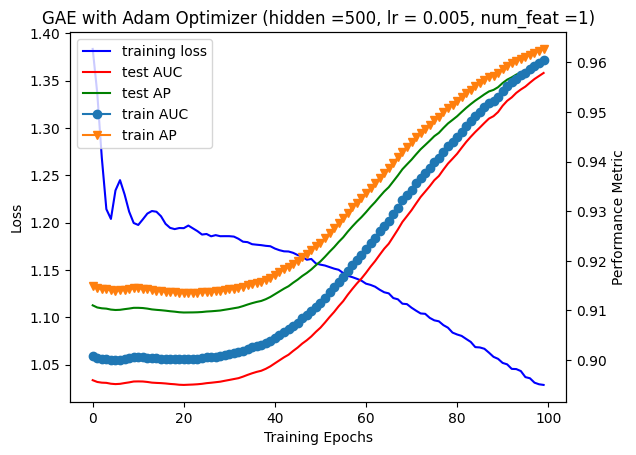

In [250]:
plot_training_stats('GAE with Adam Optimizer (hidden =500, lr = 0.005, num_feat =1)', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.607660


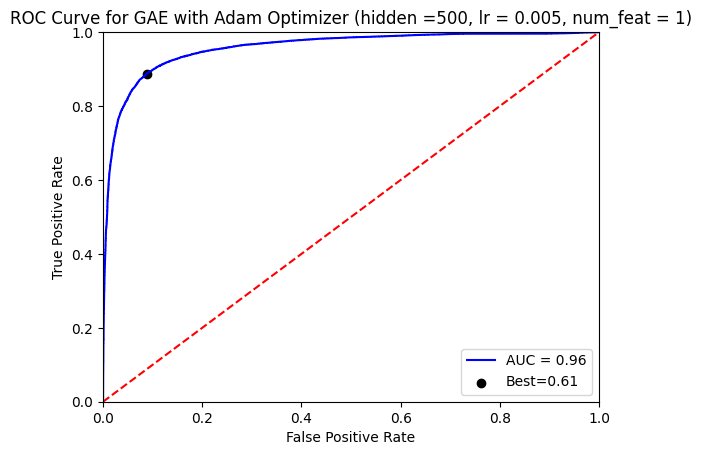

In [251]:
plot_roc_curve('ROC Curve for GAE with Adam Optimizer (hidden =500, lr = 0.005, num_feat = 1)',gae_model, test_set)

# VGAE

In [252]:
# Define the Variational GCN Encoder
class VariationalGCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_size, cached=False)
        self.conv_mu = GCNConv(hidden_size, out_channels, cached=False)
        self.conv_logstd = GCNConv(hidden_size, out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv_mu(x_temp2, edge_index), self.conv_logstd(x_temp2, edge_index)


input_dim = num_features
hidden_dim = 500 #keep
output_dim = 1
learning_rate = 0.005 #keep
epochs = 100

vgae_model = VGAE(VariationalGCNEncoder(input_dim, hidden_dim, output_dim, dropout=0.5))
vgae_model = vgae_model.to(device)

##################
##################
##################
optimizer = torch.optim.Adam(vgae_model.parameters(), lr=learning_rate)
##################
##################
##################


In [253]:
# Define the training function for VGAE
def vgae_train(train_data, vgae_model, optimizer):
    vgae_model.train()
    optimizer.zero_grad()
    z = vgae_model.encode(train_data.x.float(), train_data.edge_index)
    loss = vgae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss += (1 / train_data.num_nodes) * vgae_model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def vgae_test(test_data, vgae_model):
    vgae_model.eval()
    z = vgae_model.encode(test_data.x.float(), test_data.edge_index)
    auc, ap = vgae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)
    return auc, ap

# Training loop for VGAE
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []

for epoch in range(1, epochs + 1):
    loss = vgae_train(train_set, vgae_model, optimizer)
    losses.append(loss)
    
    train_auc, train_ap = vgae_test(train_set, vgae_model)
    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    
    test_auc_value, test_ap_value = vgae_test(test_set, vgae_model)
    test_auc.append(test_auc_value)
    test_ap.append(test_ap_value)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Test AUC: {test_auc_value:.4f}, Test AP: {test_ap_value:.4f}')

Epoch: 001, Loss: 1.7350, Train AUC: 0.7690, Train AP: 0.8332, Test AUC: 0.7562, Test AP: 0.8252
Epoch: 002, Loss: 1.5379, Train AUC: 0.9013, Train AP: 0.9167, Test AUC: 0.8972, Test AP: 0.9129
Epoch: 003, Loss: 1.4697, Train AUC: 0.8988, Train AP: 0.9144, Test AUC: 0.8943, Test AP: 0.9103
Epoch: 004, Loss: 1.4357, Train AUC: 0.9002, Train AP: 0.9155, Test AUC: 0.8957, Test AP: 0.9115
Epoch: 005, Loss: 1.4116, Train AUC: 0.9008, Train AP: 0.9160, Test AUC: 0.8964, Test AP: 0.9121
Epoch: 006, Loss: 1.3926, Train AUC: 0.9015, Train AP: 0.9165, Test AUC: 0.8970, Test AP: 0.9125
Epoch: 007, Loss: 1.3669, Train AUC: 0.9021, Train AP: 0.9169, Test AUC: 0.8976, Test AP: 0.9130
Epoch: 008, Loss: 1.3395, Train AUC: 0.9025, Train AP: 0.9171, Test AUC: 0.8980, Test AP: 0.9132
Epoch: 009, Loss: 1.3097, Train AUC: 0.9025, Train AP: 0.9170, Test AUC: 0.8979, Test AP: 0.9131
Epoch: 010, Loss: 1.2884, Train AUC: 0.9027, Train AP: 0.9171, Test AUC: 0.8982, Test AP: 0.9133
Epoch: 011, Loss: 1.2722, Trai

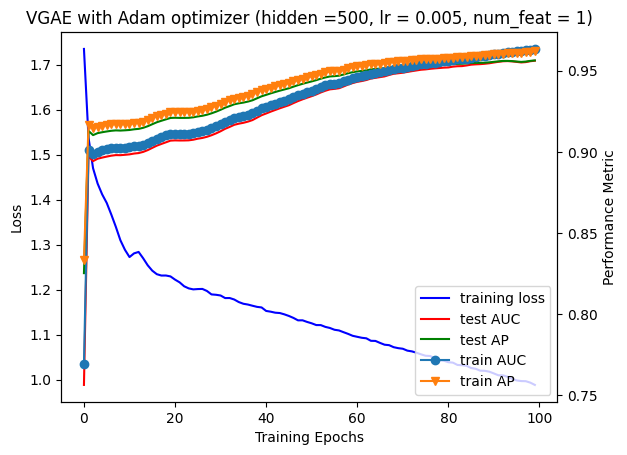

In [254]:
plot_training_stats('VGAE with Adam optimizer (hidden =500, lr = 0.005, num_feat = 1)', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.613015


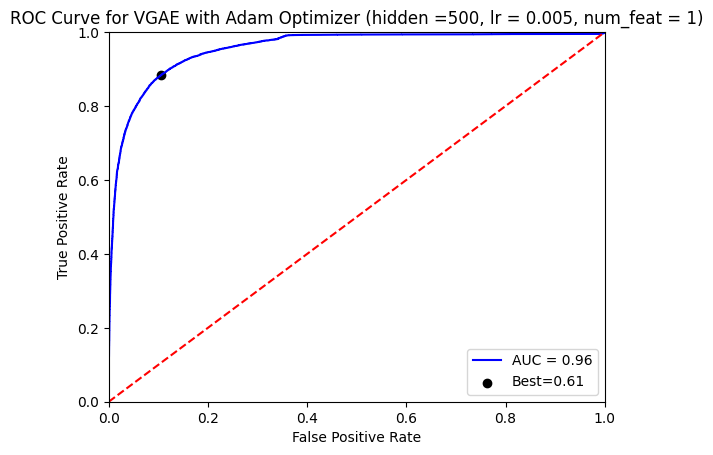

In [255]:
plot_roc_curve('ROC Curve for VGAE with Adam Optimizer (hidden =500, lr = 0.005, num_feat = 1)',vgae_model, test_set)

# holders

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
num_nodes = disgenet_torch_data.num_nodes
num_features = 20

# Initialize random features for each node
disgenet_torch_data.x = torch.randn((num_nodes, num_features))

print("Using dummy embeddings as initial node features.")
print("Number of features set to ", num_features)